# This notebook illustrates the Gaussian Process Regression

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from jax import numpy as jnp
from jax import jit, grad,vmap
from InfoGrad import InfoGrad

import pickle as pkl

%load_ext autoreload
%autoreload 2

In [104]:
# The underlying function
def f(x):
    return -1+0.01*(x-4.9)*(x+5)*(x+0.5)*(x-3.5)


# The differentiable kernel function with parameters c,l not filled.
def k(x1,x2,c,l):
    small_sig = 1e-10 # This is needed for numerical stability.
    return c * np.exp(-(np.linalg.norm(x1-x2+small_sig,axis = -1)**2) / l)

def f_sampler(X):
    Y = f(X)
    return Y+np.random.randn(*Y.shape)*0.1

def random_sample_locs(n_locs,dim_lims):
    '''
        dim_lims = [(u1,l1),(u2,l2),...,(u{space_dim},l{space_dim})]
    '''
    return (np.random.rand(n_locs, len(dim_lims)))*(dim_lims[:,-1]-dim_lims[:,0]) + dim_lims[:,0]

def GPMI(A,c,l,var_0):# The mutual information for a GP.
    KA = k(A[:,np.newaxis,:],A,c,l)
    if var_0>0:
        return 1/2*np.log(np.linalg.det(np.eye(len(KA))+(1/var_0)*KA ))
    else:
        return 1/2*np.log(np.linalg.det(KA))

In [86]:

D = 1
dim_lims = np.array([(-D,D),(-D,D)])

n_locs = 1000
var_0  = 0.01

c = 1.0
l = 100


In [92]:
A_T = random_sample_locs(n_locs, dim_lims)
A_T[:,:] = A_T[0,:]
# FA = [0]
FA=[]
for i in range(1,n_locs):
    A = A_T[:i,:]
    FA.append(GPMI(A,c,l,var_0))
    

In [112]:
A=A_T[:3,:]

In [113]:
KA = k(A[:,np.newaxis,:],A,c,l)

In [114]:
KA

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [115]:
eigs=np.linalg.eigvals(KA)

In [120]:
eigs

array([ 3.00000000e+00, -1.23259516e-32, -1.51969406e-16])

In [116]:
np.sum(np.log(1/var_0*np.abs(eigs)+1))/2

2.8535551323744452e+00

In [117]:
np.sum(np.log(1/var_0*np.abs(eigs[0])+1))/2

2.8535551323744377

In [119]:
GPMI(A,c,l,var_0)

2.8535551323744386e+00

In [121]:
1/2*np.log(1/var_0 * len(KA)+1)

2.8535551323744377

## If $F(A)$ is truely bounded above by a constant,
then we expect the blue curve's slope to gradually approach the grey curve's slope. The result shows the opposite, therefore empirical evidence seems to suggest $F(A)$ is monotone, submodular, but NOT bounded on a bounded region, that we can keep adding samples to the 1x1 region and keep the MI increasing.

Text(0.5, 0, '|A|')

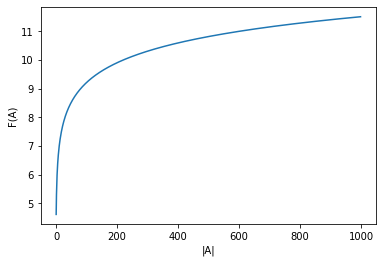

In [106]:
plt.plot(FA)
plt.ylabel('F(A)')
plt.xlabel('|A|')

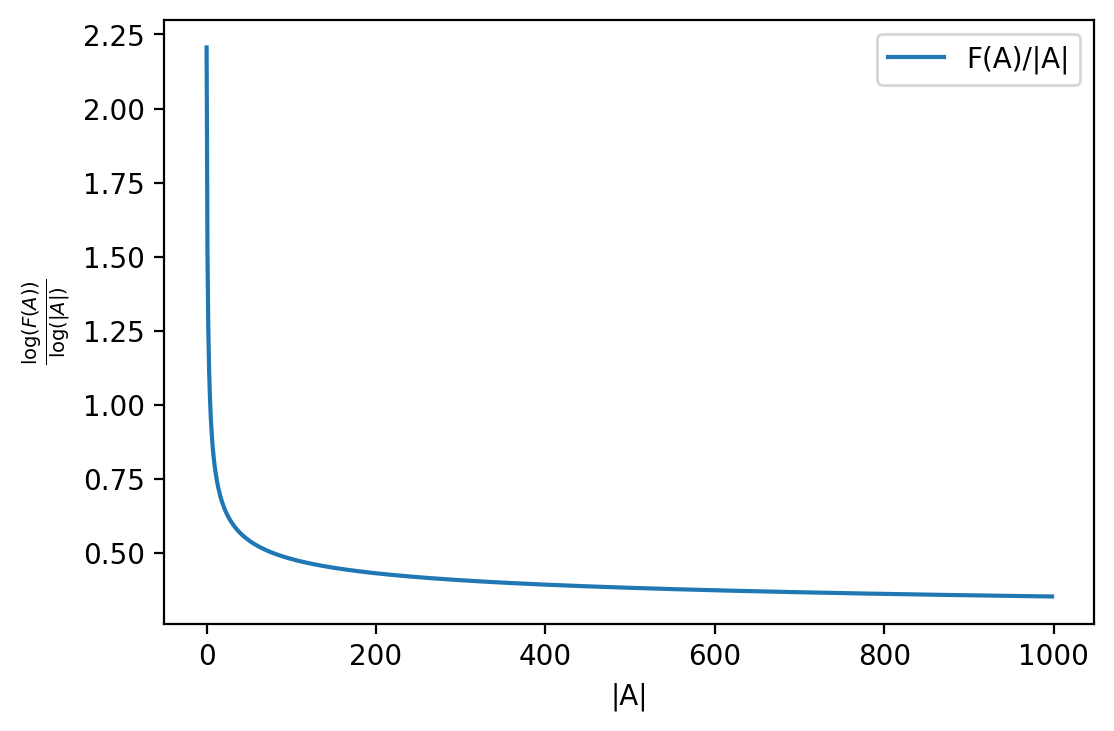

In [95]:
plt.figure(dpi=200)
plt.plot(np.log(FA)/np.log(np.arange(len(FA))+2),label='F(A)/|A|')
# plt.loglog(5/(np.arange(len(FA))+1),label = 'Boundedness baseline',color='grey')
plt.ylabel(r'$\frac{\log(F(A))}{\log(|A|)}$')
plt.xlabel('|A|')
plt.legend()

Text(0.5, 0, '|A|')

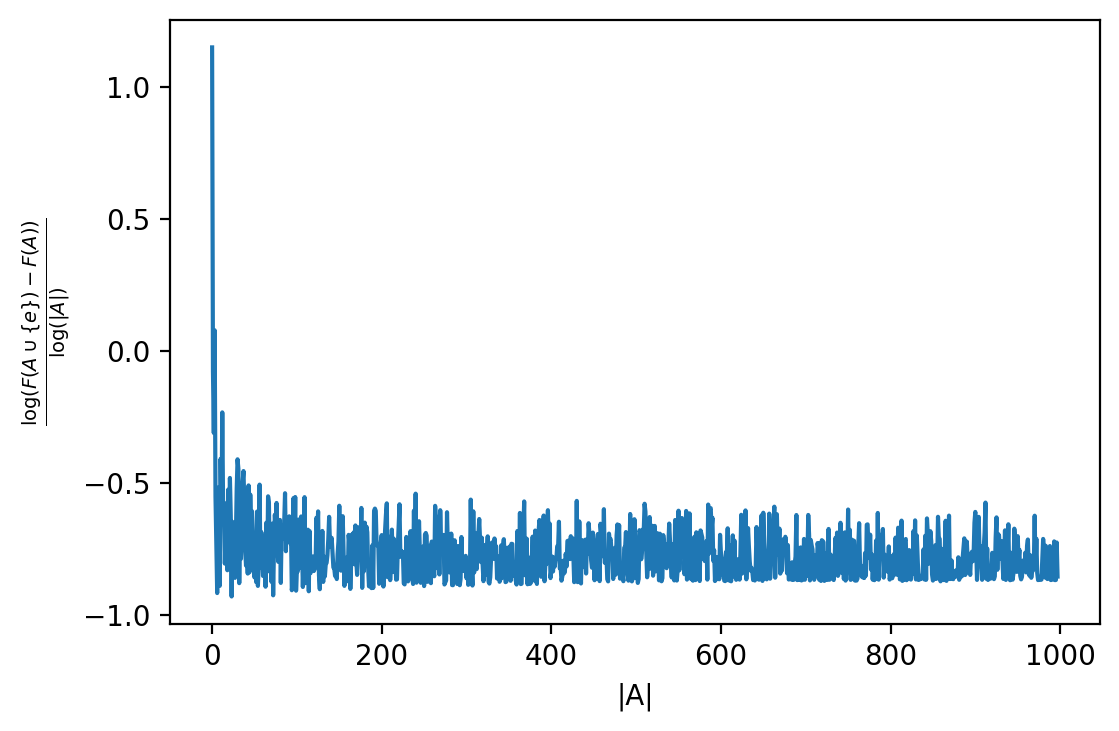

In [79]:

FA = np.array(FA)
plt.figure(dpi=200)
plt.plot(np.log(FA[1:]-FA[:-1])/np.log(np.arange(len(FA)-1)+2))
# plt.plot(FA[1:]-FA[:-1])
plt.ylabel(r'$\frac{\log(F(A\cup\{e\})-F(A))}{\log(|A|)}$')
plt.xlabel('|A|')

**The interesting thing is that F(A) eventually converges to some $|A|^c$, with $c<1$.**

# Experiment with different $D$ and plot relationship with final $\log(F(A))/\log(|A|)$

In [71]:
Ds = np.array([1,2,3,4,5])

sample_per_area = 50
var_0  = 0.01

c = 1.0
l = 100

final_ratio = []

for D in Ds:
    
    print('D=',D)
    
    dim_lims = np.array([(-D,D),(-D,D)])

    A_T = random_sample_locs(sample_per_area*D**2, dim_lims)
    # FA = [0]
    FA=[]
    for i in range(1,n_locs):
        A = A_T[:i,:i]
        FA.append(GPMI(A,c,l,var_0))
    
    final_ratio.append(np.log(FA[-1])/np.log(len(FA)))

D= 1
D= 2
D= 3
D= 4
D= 5


Text(0, 0.5, 'final $\\log(F(A))/\\log(|A|)$')

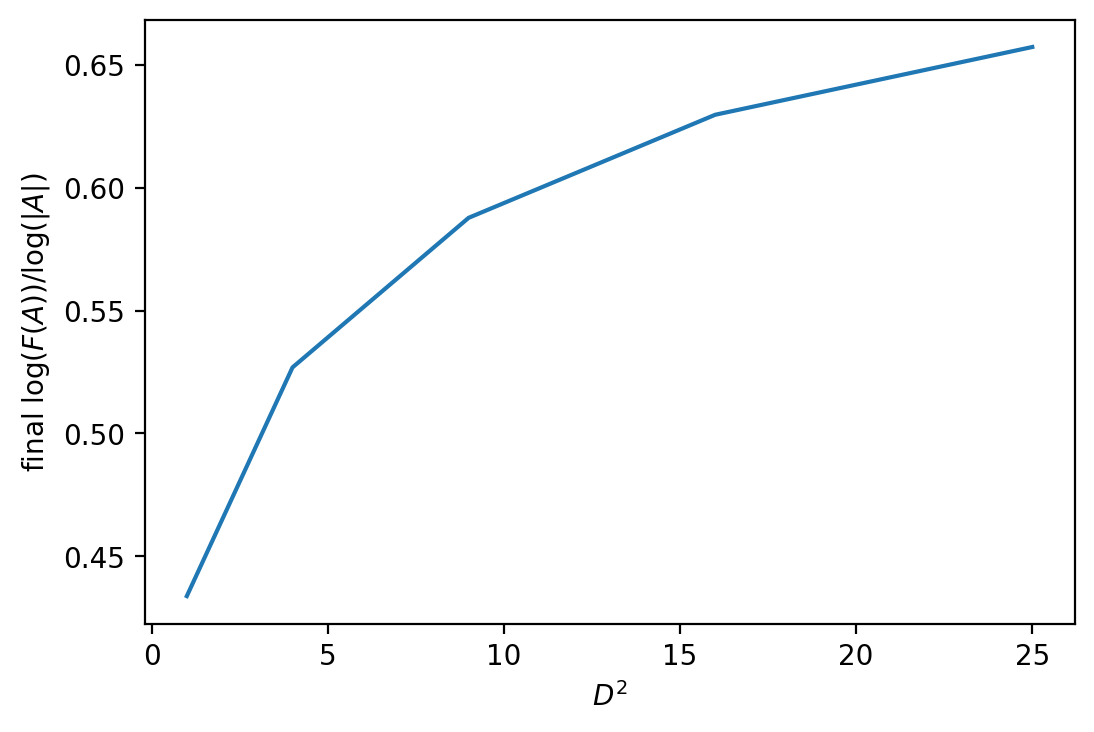

In [74]:
plt.figure(dpi=200)
plt.plot(Ds**2,final_ratio)
plt.xlabel(r'$D^2$')
plt.ylabel(r'final $\log(F(A))/\log(|A|)$')

**If F(A) eventually converges to $|A|^c$, with $c<1$, then the $c$ values seems to increase as the search area increases.**